## Airport Scheduling Problem 

### simplifying assumptions
- airport only "open" between 6:00 AM and 11:59 PM  


### Process Description 
* The airport environment is modelled as a Markov Decision Process, including
    * Stages / Time: $t$
        * Time steps in hours
        * $t = 0, 1, 2, ..., T$
    * States: $x_t$
        * Number of arriving passengers waiting in the queue (customs) given time step
        * $x_t = 0, 1, 2, ..., \text{waiting capacity}$
    * Actions: $u_t$
        * Number of on-demand customs officers to hire given time step
        * Is not defined for $t=T$ (airport closed)
        * $u_t = 0, 1, 2, ..., \text{max number of customs officers}$
    * Transitions: $f_t(x_t, u_t)$
        * Characterisation of state in next period
        * $x_{t+1}=f(x_t,u_t)=[x_t+d_t-2(u_t+10)]^+$
            * $d_t$ is the number of passengers arriving to customs area in the current hour
                * Follows:
                    * 1) the poisson distribution at t for a stochastic transition, where lambdas are modeled from historical data
                      2) a deterministic arrival schedule based on historical data
            * The formula assmued airport already has 2 permanent customs officers, and each doctor on average can treat 15 patients per hour
    * Costs: $g_t, g_T$
        * Cost per Stage: $g_t(x_t, u_t)$
            * If Cost of on-demand customs officer is 500/doc-hour; cost of one passenger waiting per hour is 30:
                * $g_t(x_t, u_t) = 500u_t + 30x_t$
        * Terminal Cost: $g_T(x_T)$
            * If there are still passengers waiting at the end of the day, the airport will incur a cost of 300 per passenger:
                * $g_T(x_T) = 300x_T$
            
    



### Here we solve the airport scheduling problem backward induction.


- Clinic opens at 8am, and closes at 8pm
- w = 200 (patient waiting cost, per patient per hour)
- W = 400 (abandonment cost of not treating a patient)
- wage = 500 per on-demand doctor per hour (there are 10 doctors already scheduled for each hour, and you can ignore their wage since that doesn't change the calculations)
- patient arrival process: at the beginning of every hour t, D_t patients arrive. All the D_t's are i.i.d. Poisson random variables with lambda = 5.
- The initial number of patient (x_1) is anywhere between 0 and 70. (Think of these patients as having arrived before 8am and been waiting)

In [1]:
'''
Building the Airport Environment
'''

from hospital_env import HospitalEnv as AirportEnv
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import poisson
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

# # Set the mean (lambda) for the Poisson distribution
# mean = 5
# # Define the desired array length (similar to the length of the given array)
# array_length = 24
# # Generate an array of Poisson-distributed random variables with mean 5
# arrival_distrib = mean + poisson.rvs(mu=5, size=array_length)


In [48]:
# Initialize the environment
hospital_env = HospitalEnv(arrival_distrib=arrival_distrib,
                            open_time=8,
                            work_hours=12,
                            patient_waiting_cost=200,
                            doc_cost=500,
                            waiting_capacity=70,
                            max_on_demand_doc=10,
                            patient_not_treated_cost=400,
                            default_queue_length=15)

### Run the Stochastic Backward Induction Algorithm

In [49]:
'''
Run the Stochastic Backward Induction Algorithm
'''
from BI_solver_sto import BISolverSto

solver_sto = BISolverSto(env=hospital_env)
policy_sto, cost_sto = solver_sto.backward_induction()



## Optimal Policy - Stochastic - Tabular

In [50]:
policy_opt = pd.DataFrame(policy_sto)
policy_opt.columns = range(8,20)
policy_opt




,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
66,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
67,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
68,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
69,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


## Optimal Policy - Stochastic - Heatmap

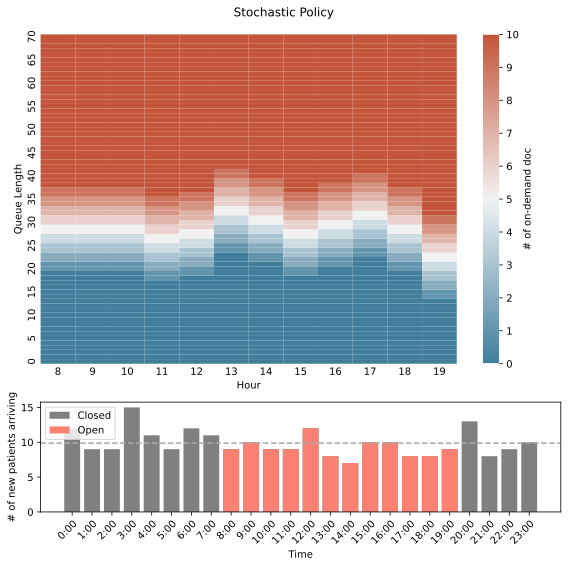

In [51]:
hospital_env.visualize_policy(policy_sto, "Stochastic Policy")

##  cost-to-go values - Tabular

In [52]:
cost_to_go = pd.DataFrame(cost_sto)
cost_to_go.columns = range(8,21)
cost_to_go

,8,9,10,11,12,13,14,15,16,17,18,19,20
0,7.178946,7.034172,6.476706,6.332586,6.183838,1.494870,1.466034,1.461827,0.901478,0.345236,0.316384,0.287418,0.0
1,207.391841,207.727645,206.688569,206.551596,210.449810,201.545468,201.474969,202.159223,201.593238,200.395863,200.367229,200.709800,400.0
2,407.881299,409.170928,407.175528,407.055593,417.953926,401.675570,401.501107,403.611203,403.032643,400.526047,400.498008,401.680361,800.0
3,608.955064,612.039734,608.243480,608.162488,630.589279,601.994500,601.573951,606.498571,605.892980,600.845198,600.818723,603.808189,1200.0
4,811.198590,817.476569,810.474028,810.478277,850.930297,802.738314,801.766950,811.973522,811.311976,801.589577,801.567057,808.250553,1600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,31202.347393,31406.558577,31130.323506,31658.034573,31915.346864,30025.848108,30347.637445,31587.681294,31068.611388,30307.601908,31385.959114,32200.000000,26400.0
67,31858.481244,32064.938866,31796.024140,32317.721767,32570.561784,30676.567520,30999.868434,32244.253234,31720.890123,30960.918265,32118.552799,32800.000000,26800.0
68,32518.788227,32728.485579,32469.853301,32983.155401,33229.068406,31328.050193,31654.182085,32904.998091,32374.995932,31617.088233,32870.013603,33400.000000,27200.0
69,33185.239247,33399.377470,33154.234579,33656.511954,33892.391738,31980.947622,32312.021572,33571.755191,33032.059242,32277.945302,33637.980564,34000.000000,27600.0


##  cost-to-go values - Heatmap

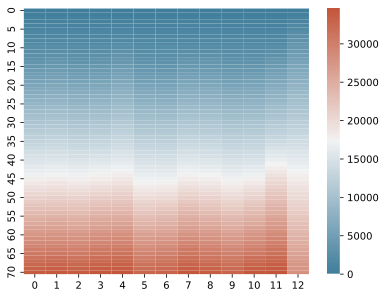

In [53]:
heatmap = sns.heatmap(cost_sto, 
                      cmap=sns.diverging_palette(230, 20, as_cmap=True),
                      yticklabels=5
                      )

### Sensitivity analysis: Change the values of w and W, and describe how the optimal policy changes as w and W changes. 

### Scenario 1 - High Cost of On Demand Doctors, Low Cost of Patient-Hour Wait

- in this scenario we will keep constant the cost of on demand doctor hours and **halve** the cost of patient waiting cost (from 200 to 100)
- as a result, the optimal policy suggests hiring on demand doctors at much higher patient queue threshholds compared to the optimal policy according to the original parameters. 
- The trend towards hiriing more on demand doctors towards the end of the working hours likely reflects the cost of untreated patients, which was kept constant in this scenario.
 

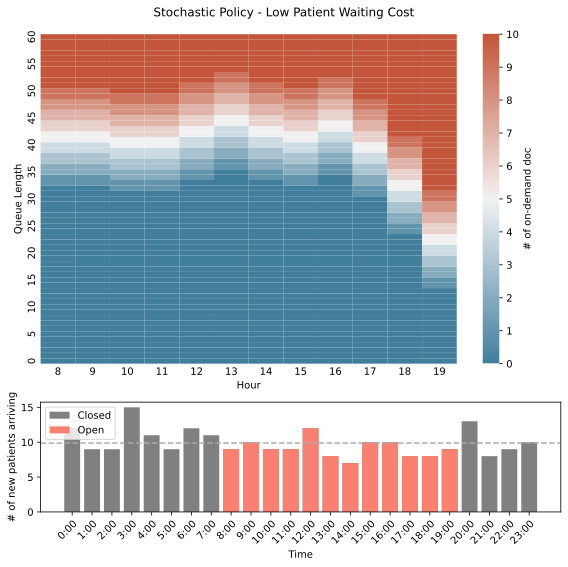

In [54]:
# Initialize the environment
hospital_env = HospitalEnv(arrival_distrib=arrival_distrib,
                            open_time=8,
                            work_hours=12,
                            patient_waiting_cost=100,
                            doc_cost=500,
                            waiting_capacity=60,
                            max_on_demand_doc=10,
                            patient_not_treated_cost=400,
                            default_queue_length=50)


solver_sto = BISolverSto(env=hospital_env)
policy_sto, cost_sto = solver_sto.backward_induction()

# 
hospital_env.visualize_policy(policy_sto, "Stochastic Policy - Low Patient Waiting Cost")



### Scenario 2 - Low Cost of On Demand Doctors

- in this scenario we will keep constant the cost of patient waiting costs, and lower the cost of on demand doctor hours (from 500 to 250)
- as a result, the optimal policy suggests hiring on demand doctors at lower patient queue threshholds compared to the optimal policy according to the original parameters. 


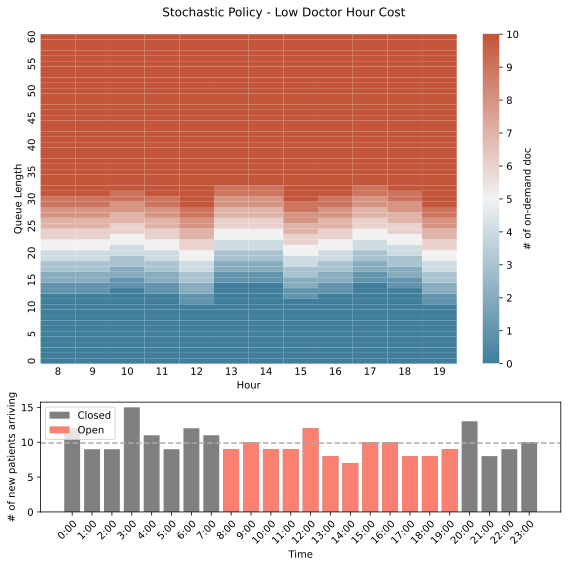

In [55]:
# Initialize the environment
hospital_env = HospitalEnv(arrival_distrib=arrival_distrib,
                            open_time=8,
                            work_hours=12,
                            patient_waiting_cost=200,
                            doc_cost=250,
                            waiting_capacity=60,
                            max_on_demand_doc=10,
                            patient_not_treated_cost=400,
                            default_queue_length=50)


solver_sto = BISolverSto(env=hospital_env)
policy_sto, cost_sto = solver_sto.backward_induction()

# 
hospital_env.visualize_policy(policy_sto, "Stochastic Policy - Low Doctor Hour Cost")

